In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`


In [2]:
using DynamicalSystems, DifferentialEquations

using Statistics
using StaticArrays
using CairoMakie
using JLD

In [3]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [4]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

peaks (generic function with 1 method)

In [5]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,500000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,500000), pdf
end

CALCPDF (generic function with 1 method)

In [6]:
tspan = (0., 500000.)

a = 1.
b = 3.
c = 1.
d = 5.
xr = -1.6
r = 0.01
s = 5.
I = 4.
xv = 2.


k1= -0.17
k2 = k1

-0.17

In [7]:
k  = 0.3012
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.3012

In [8]:
condition = SA[-0.04471856203156402,
   0.9930479522101472,
   4.4905558028862576,
  -1.6784956837442249,
 -12.985436806629679,
   4.185702440686755]

6-element SVector{6, Float64} with indices SOneTo(6):
  -0.04471856203156402
   0.9930479522101472
   4.4905558028862576
  -1.6784956837442249
 -12.985436806629679
   4.185702440686755

In [9]:
prob = ODEProblem(HR, condition, tspan, p)

ODEProblem with uType SVector{6, Float64} and tType Float64. In-place: false
timespan: (0.0, 500000.0)
u0: 6-element SVector{6, Float64} with indices SOneTo(6):
  -0.04471856203156402
   0.9930479522101472
   4.4905558028862576
  -1.6784956837442249
 -12.985436806629679
   4.185702440686755

In [10]:
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [11]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

before: 7693798
after: 5770350


In [12]:
x1, x2 = sol[1, :], sol[4, :]
println("length x1, x2 before truncate:", length(x1), ", ", length(x2))
x1 = x1[floor(Int, length(x1) / 4):end ]
x2 = x2[floor(Int, length(x2) / 4):end ]
println("length x1, x2 after truncate:", length(x1), ", ", length(x2))

length x1, x2 before truncate:7693798, 7693798
length x1, x2 after truncate:5770350, 5770350


In [13]:
Hs1 = Hs(xsum, 6)

2.667786214644109

In [14]:
CairoMakie.activate!()

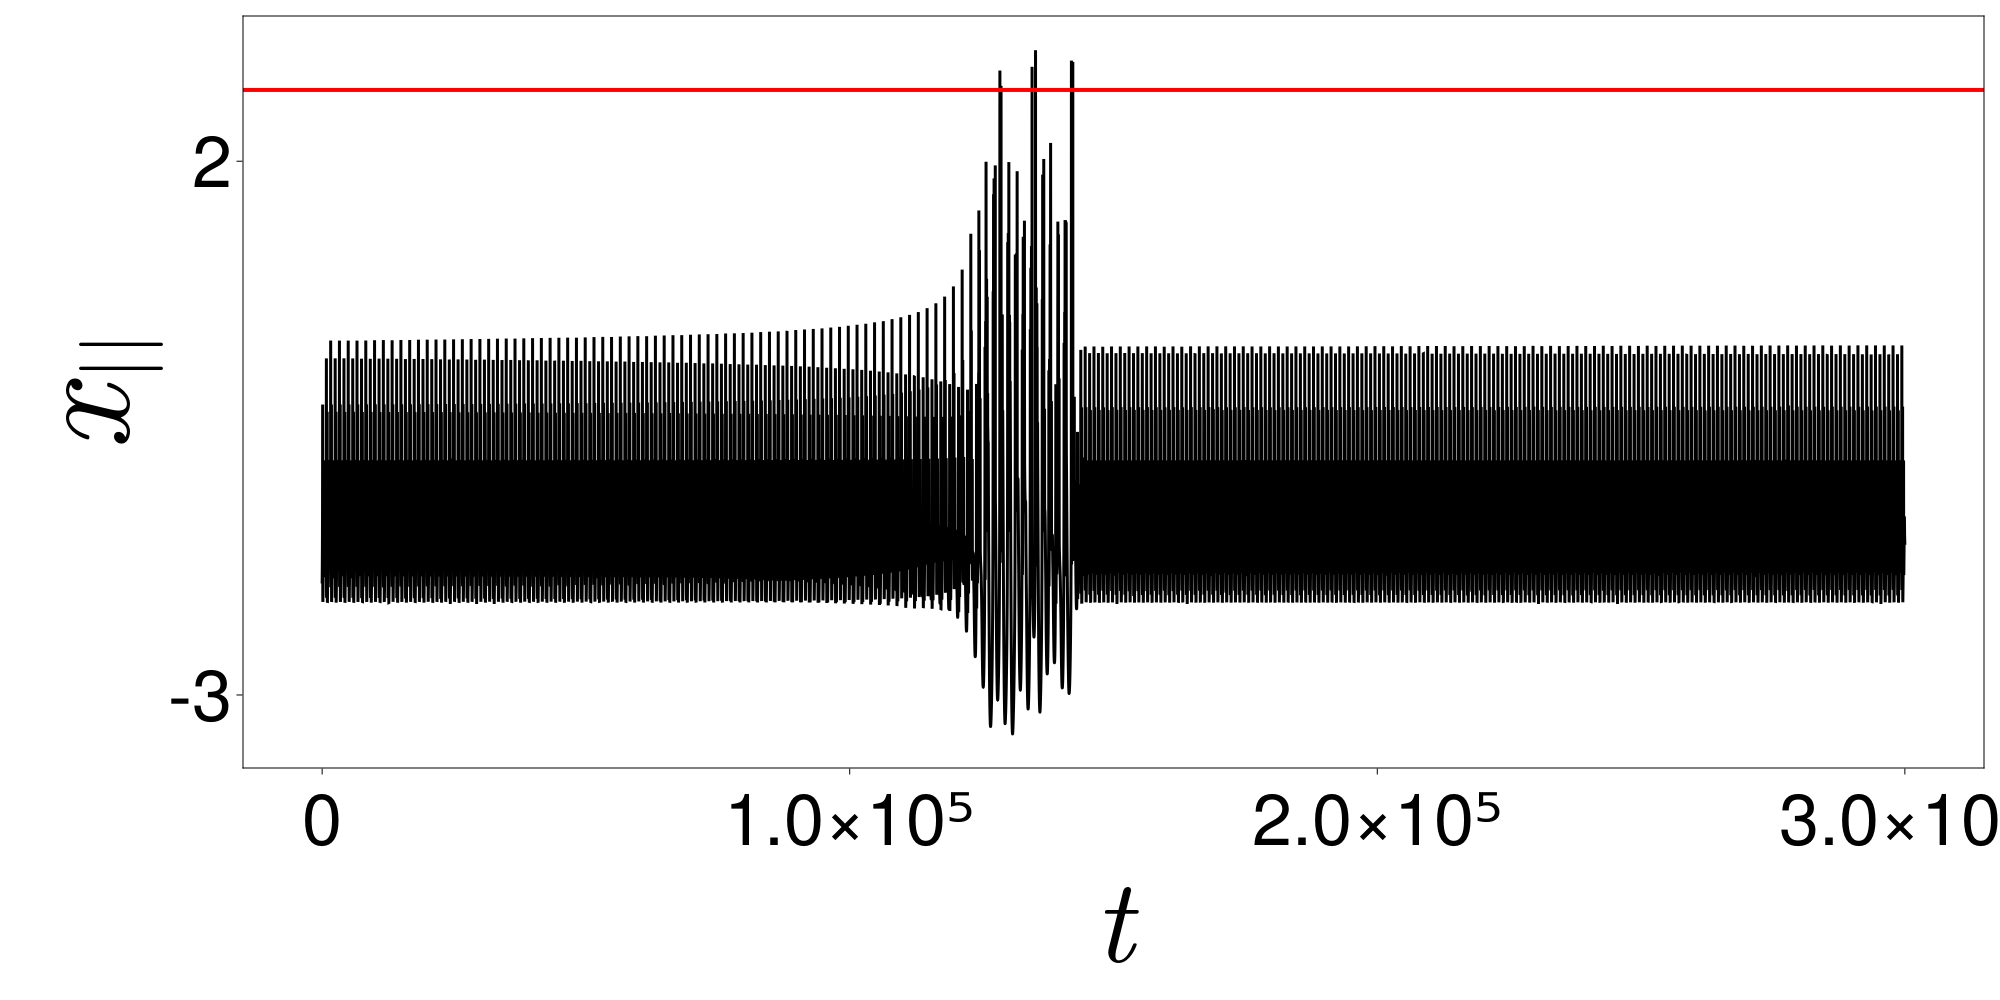

In [15]:
f = Figure(resolution = (2000, 1000))

ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{||}",
xlabelsize = 120, ylabelsize = 140,
                xticklabelsize = 72, yticklabelsize = 72, yticks = [-3, 2])

ax.xgridvisible = false
ax.ygridvisible = false

lines!(ax, xsum[3750000:4050000], linewidth = 3.0, color = "black")
# hlines!(Hs2, color = "red", linewidth = 1.0, linestyle = :dash)
hlines!(Hs1, color = "red", linewidth = 4.0)
save("intermittency_timeseries.eps", f)
f

In [15]:
sel_1, pdf_1 = CALCPDF(xsum)

(0.0:8.000016000032e-6:4.0, [0.02384153474226, 0.023841188142833623, 0.023841014843120435, 0.023841014843120435, 0.023841188142833623, 0.023841014843120435, 0.023841014843120435, 0.02384049494398087, 0.023840668243694057, 0.02384049494398087  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [16]:
using JLD

In [17]:
save("sel_1_intermittency.jld", "data", sel_1  )
save("pdf_1_intermittency.jld", "data", pdf_1  )

In [22]:
cd("C:\\Users\\Alex\\YandexDisk\\Science\\HR\\PDF")

sel_1 = load("sel_1_intermittency.jld")["data"]
pdf_1 = load("pdf_1_intermittency.jld")["data"];

In [23]:
EE_mapcopy = pdf_1;
EE_mapcopy = [ iszero(x) ? NaN : x for x in EE_mapcopy ];

In [24]:
sel_1EE_mapcopy = sel_1;
sel_1EE_mapcopy = [ iszero(x) ? NaN : x for x in sel_1EE_mapcopy ];

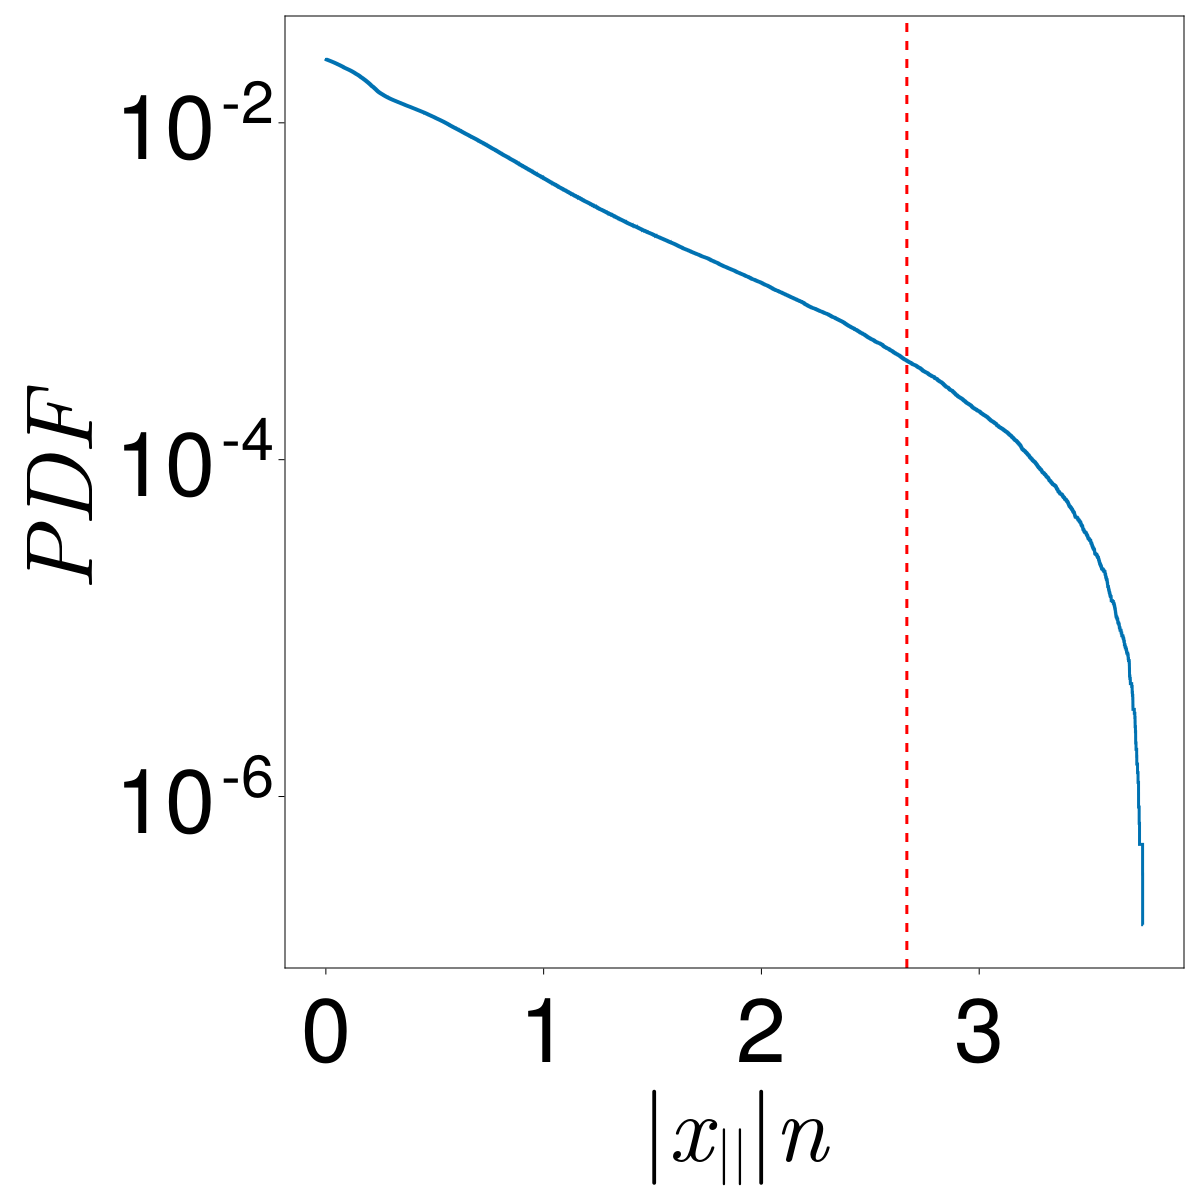

In [33]:
f = Figure(resolution = (1200, 1200))

ax = Axis(f[1, 1], yscale = log10,
xlabel = L"|x_{||}|n", ylabel = L"PDF",
xlabelsize = 95, ylabelsize = 95,
xticklabelsize = 90, yticklabelsize = 90  )

ax.xgridvisible = false
ax.ygridvisible = false
lines!(sel_1EE_mapcopy, EE_mapcopy, linewidth = 3.0)
vlines!(ax, Hs1, color = "red", linestyle = :dash, linewidth = 3.0)

save("PDF_intermittency.eps", f)

f

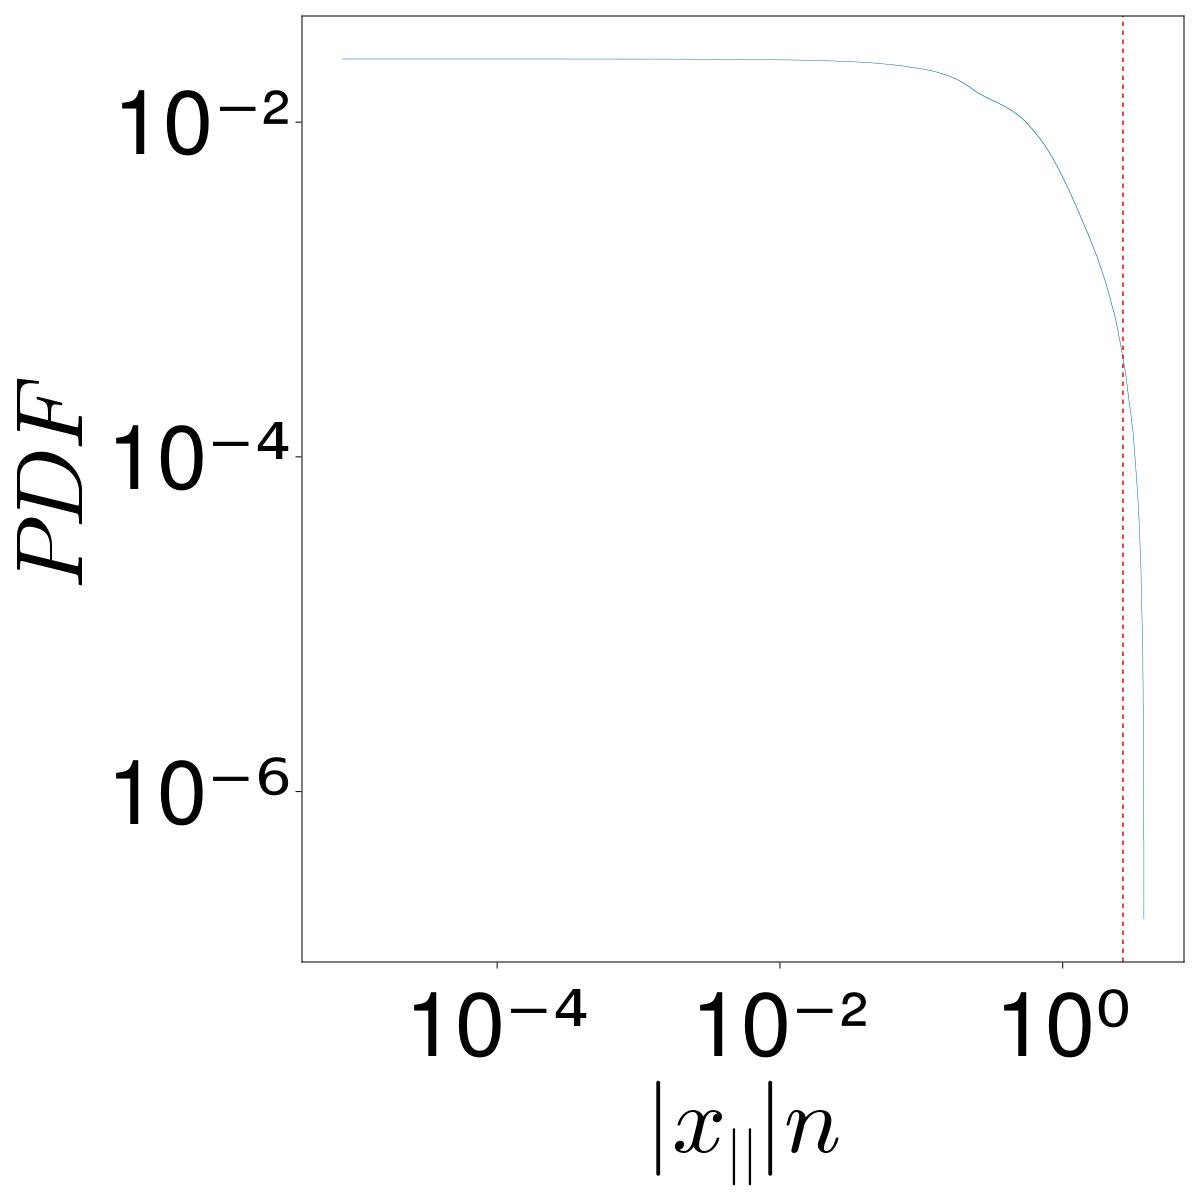

In [23]:
f = Figure(resolution = (1200, 1200))

ax = Axis(f[1, 1], yscale = log10, xscale = log10,
xlabel = L"|x_{||}|n", ylabel = L"PDF",
xlabelsize = 95, ylabelsize = 95,
xticklabelsize = 90, yticklabelsize = 90  )

ax.xgridvisible = false
ax.ygridvisible = false
lines!(sel_1EE_mapcopy, EE_mapcopy, linewidth = 0.5)
vlines!(ax, Hs1, color = "red", linestyle = :dash)

save("PDF_intermittency.eps", f)

f

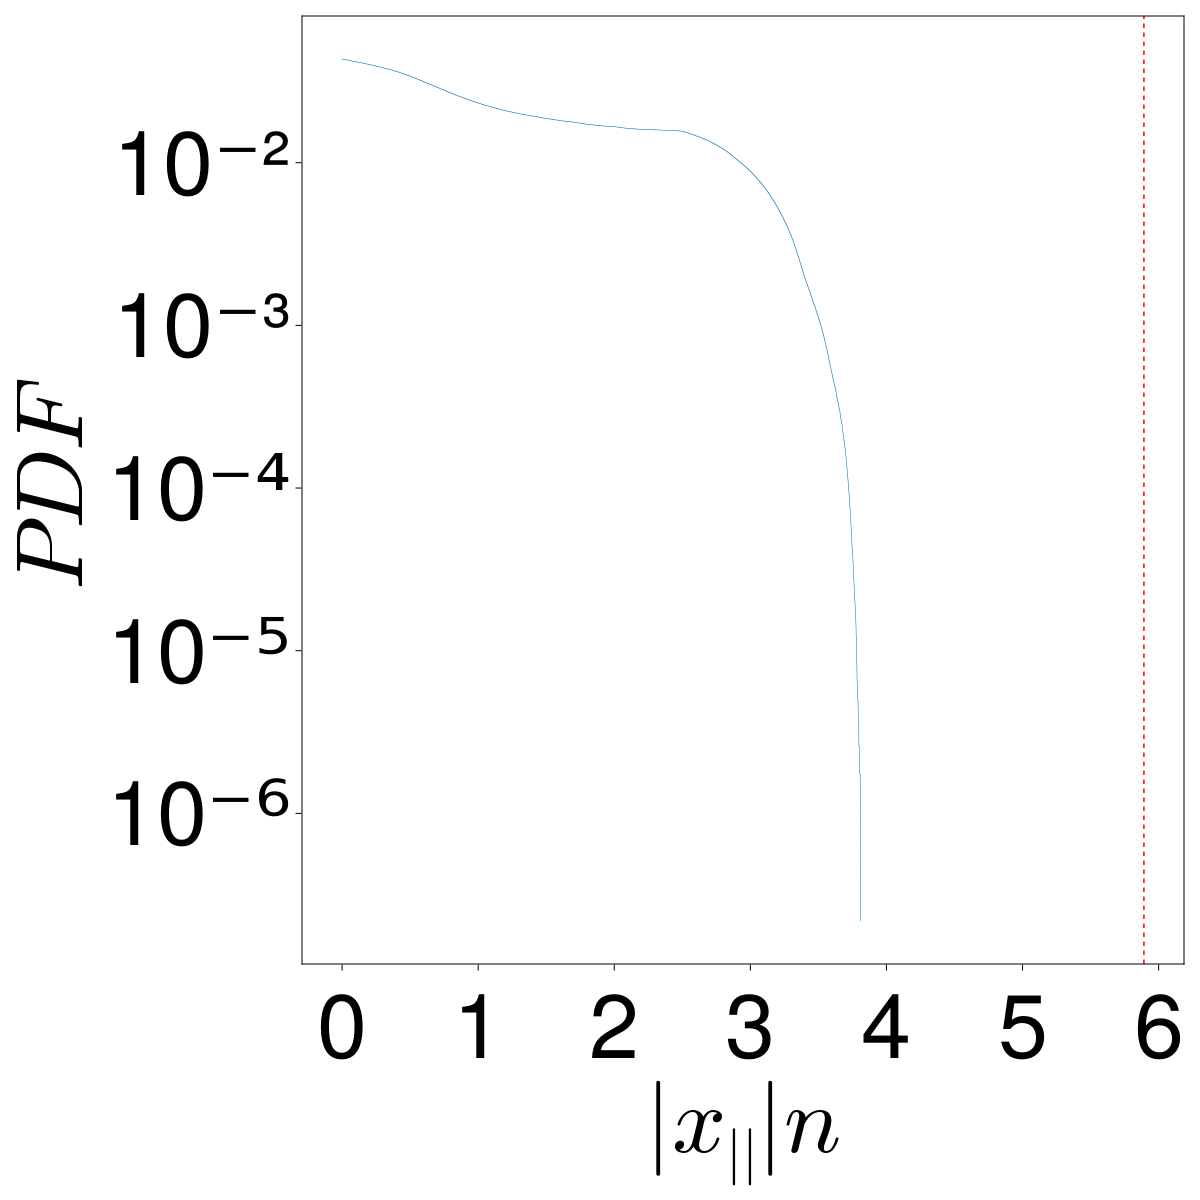

In [20]:
f = Figure(resolution = (1200, 1200))

ax = Axis(f[1, 1], yscale = log10,
xlabel = L"|x_{||}|n", ylabel = L"PDF",
xlabelsize = 95, ylabelsize = 95,
xticklabelsize = 90, yticklabelsize = 90  )

ax.xgridvisible = false
ax.ygridvisible = false
lines!(sel_1, EE_mapcopy, linewidth = 0.5)
vlines!(ax, Hs1, color = "red", linestyle = :dash)
save("PDF_chaos_positive.eps", f)
f

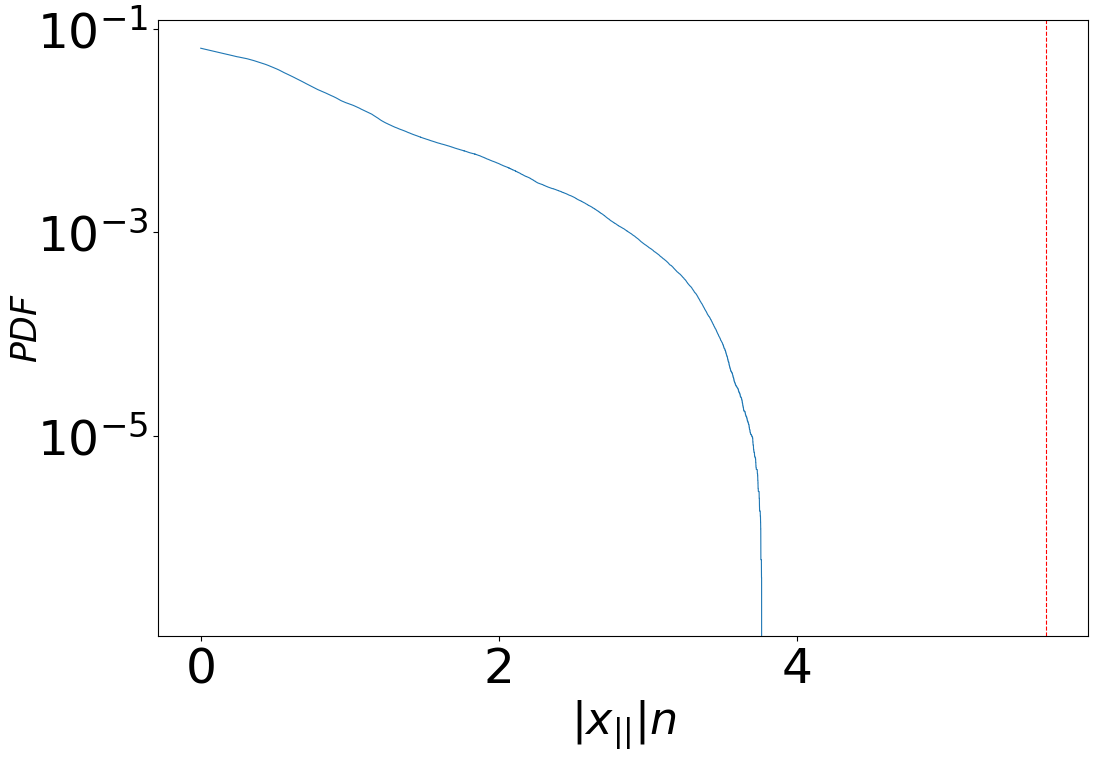

In [68]:
counts = xsum[xsum.>=Hs1]
counts = length(counts)

fig, ax = subplots(figsize = (12, 8))

ax.set_yscale("log")

ax.plot(sel_1, pdf_1, label  = "k: $k", lw  = 0.8)
ax.axvline(Hs1, color ="red", linestyle ="--", lw = 0.8, label = "count: $counts")
ax.tick_params(labelsize = 35)
ax.set_xlabel(L"|x_{||}|n", fontsize = 32)

ax.set_ylabel(L"PDF", fontsize = 25, labelpad = -5)

# ax.legend(loc="upper left", fontsize = 25)

savefig("PDF_chaos.eps", format = "eps")

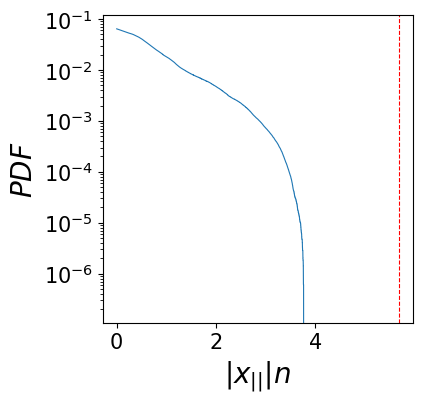

PyObject Text(37.99999999999999, 0.5, '$PDF$')

In [48]:
counts = xsum[xsum.>=Hs1]
counts = length(counts)

fig, ax = subplots(figsize = (4, 4))

ax.set_yscale("log")

ax.plot(sel_1, pdf_1, label  = "k: $k", lw  = 0.8)
ax.axvline(Hs1, color ="red", linestyle ="--", lw = 0.8, label = "count: $counts")
ax.tick_params(labelsize = 15)
ax.set_xlabel(L"|x_{||}|n", fontsize = 20)
ax.set_ylabel(L"PDF", fontsize = 20)
# ax.legend(loc="upper left", fontsize = 25)

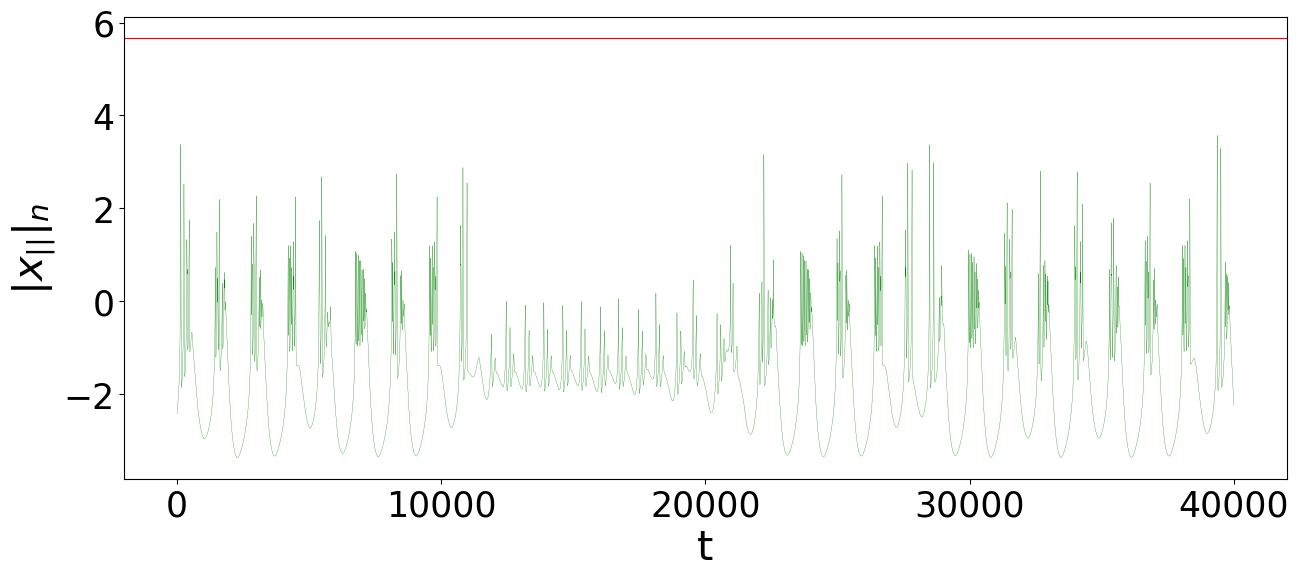

In [23]:
fig, ax = subplots(figsize = (15, 6))

ax.plot(xsum[30000:70000], label  = "k: $k", lw  = 0.2, color = "green")
ax.axhline(Hs1, color ="red", lw = 0.8)
ax.tick_params(labelsize = 25)
ax.set_xticks([0, 10000, 20000, 30000, 40000])
ax.set_xlabel("t", fontsize = 30)
ax.set_ylabel(L"|x_{||}|_{n}", fontsize = 30)

savefig("timesrieschaos.eps", format = "eps")

In [147]:
ds = ContinuousDynamicalSystem(HR, condition_chaos, p)
spectrum = lyapunovspectrum(ds, 300000.0; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
spectrum

6-element Vector{Float64}:
   0.011633579523620714
   4.3871302821537545e-6
  -0.03287379268030042
  -0.05940096639691879
  -8.27704785079715
 -10.714821326426874

In [123]:
k_space = range(0.424, 0.425, step = 0.00004)
spectrum_ma = zeros(length(k_space), 6)

26×6 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [129]:
for (index, k_) in enumerate(k_space)
    
    if index == 1
        global u0 = condition_chaos
        init = 1
    else
        init = 0
    end
    
    println("index: $index"); flush(stdout)
    println("k: $k_"); flush(stdout)
    
    if init == 1
        println("initialization ODE"); flush(stdout)
    end
    
    p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k_]
    prob = ODEProblem(HR, condition_chaos, (0.0, 300000.0), p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);
    u0 = sol[end]
    println("last point: $u0"); flush(stdout)
    
     if init == 1
        println("initialization DS"); flush(stdout)
    end
    ds = ContinuousDynamicalSystem(HR, condition_chaos, p)
    spectrum = lyapunovspectrum(ds, 300000.0; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_ma[index, :] = spectrum
    println("spectrum: $spectrum")
    
    println(">>>>>>>>>>>>"); flush(stdout)
    println("  "); flush(stdout)
    
    
end

index: 1
k: 0.424
initialization ODE
last point: [-1.359341581609195, -8.353577391631694, 3.6211183146536534, -1.5253268719567075, -10.850615917911334, 3.733123580063242]
initialization DS
spectrum: [0.011637187938794945, -4.851392860722672e-6, -0.032864343662495514, -0.05940317726757377, -8.277041257333364, -10.714829527932517]
>>>>>>>>>>>>
  
index: 2
k: 0.42404
last point: [-0.05585789225514796, 0.5182643677282703, 4.104868861059059, 0.7191071332958213, -0.008329078939430112, 4.271131036521903]
spectrum: [0.011421420501177988, -6.72897760727636e-6, -0.03298458204278394, -0.05988559220126002, -8.277056283216268, -10.714961820498761]
>>>>>>>>>>>>
  
index: 3
k: 0.42408
last point: [-0.7408724195713802, -2.150972152452104, 3.8099777335551686, -0.8723480741753318, -3.2613092746820223, 3.789313695058545]
spectrum: [0.011225005453796734, 2.3633964226083593e-5, -0.03372593175713667, -0.06046015903955126, -8.289138691559684, -10.710632901116771]
>>>>>>>>>>>>
  
index: 4
k: 0.42412
last poin

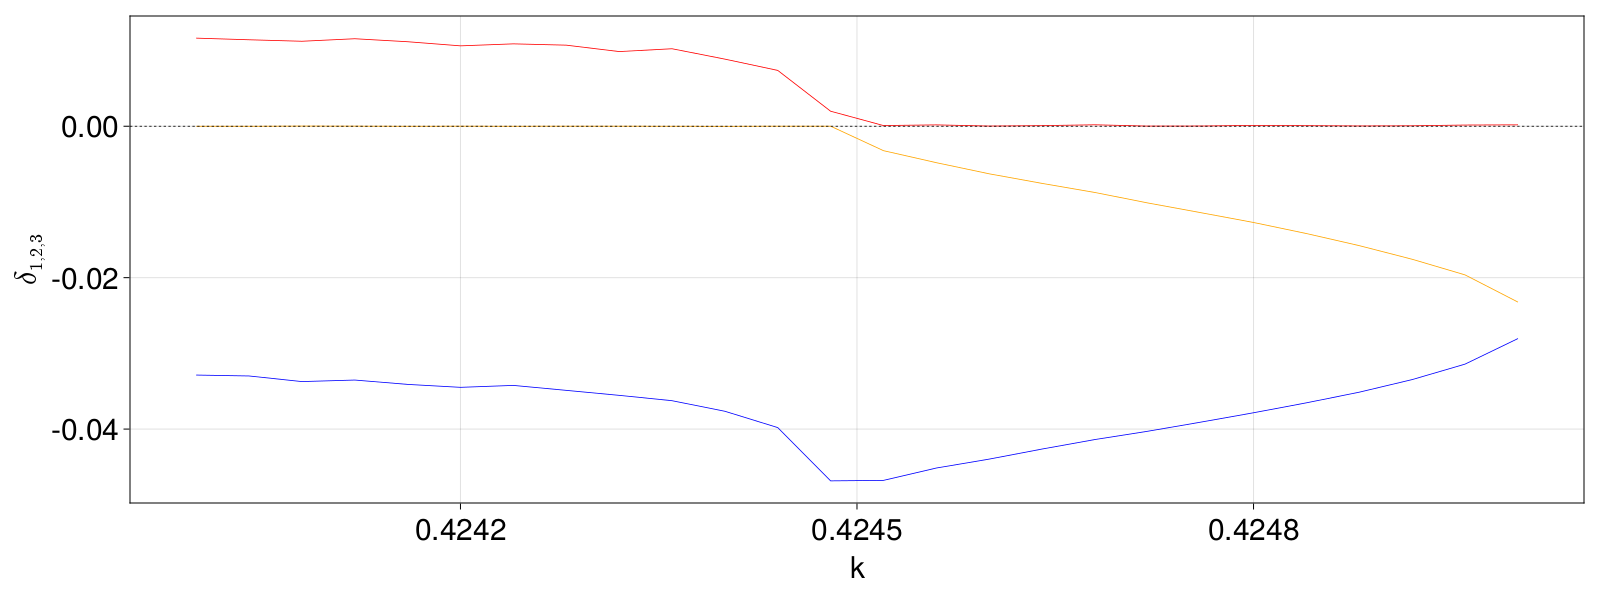

In [132]:
f = Figure(resolution = (1600, 600), fontsize = 30)
ax = Axis(f[1, 1], xlabel = "k", ylabel = L"\delta_{1, 2, 3}")
le1 = lines!(ax, k_space[:], spectrum_ma[:, 1], linewidth = 0.8, color = "red")
le2 = lines!(ax, k_space[:], spectrum_ma[:, 2], linewidth = 0.8, color = "orange")
le3 = lines!(ax, k_space[:], spectrum_ma[:, 3], linewidth = 0.8, color = "blue")
zero = hlines!(ax, 0.0, linewidth = 0.8, linestyle = :dash, color = "black")
f

### another attractor

In [10]:
condition_ = SA[  
  0.01
  0.01
  0.01
  0.01
  0.01
  0.01]

k  = 0.424
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.424

In [11]:
prob = ODEProblem(HR, condition_, tspan, p)
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [12]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

before: 5558837
after: 4169129


In [13]:
x1, x2 = sol[1, :], sol[4, :]
println("length x1, x2 before truncate:", length(x1), ", ", length(x2))
x1 = x1[floor(Int, length(x1) / 4):end ]
x2 = x2[floor(Int, length(x2) / 4):end ]
println("length x1, x2 after truncate:", length(x1), ", ", length(x2))

length x1, x2 before truncate:5558837, 5558837
length x1, x2 after truncate:4169129, 4169129


In [14]:
spikes = peaks(xsum);
Hs1 = Hs(spikes, 6)

4.953899129318334

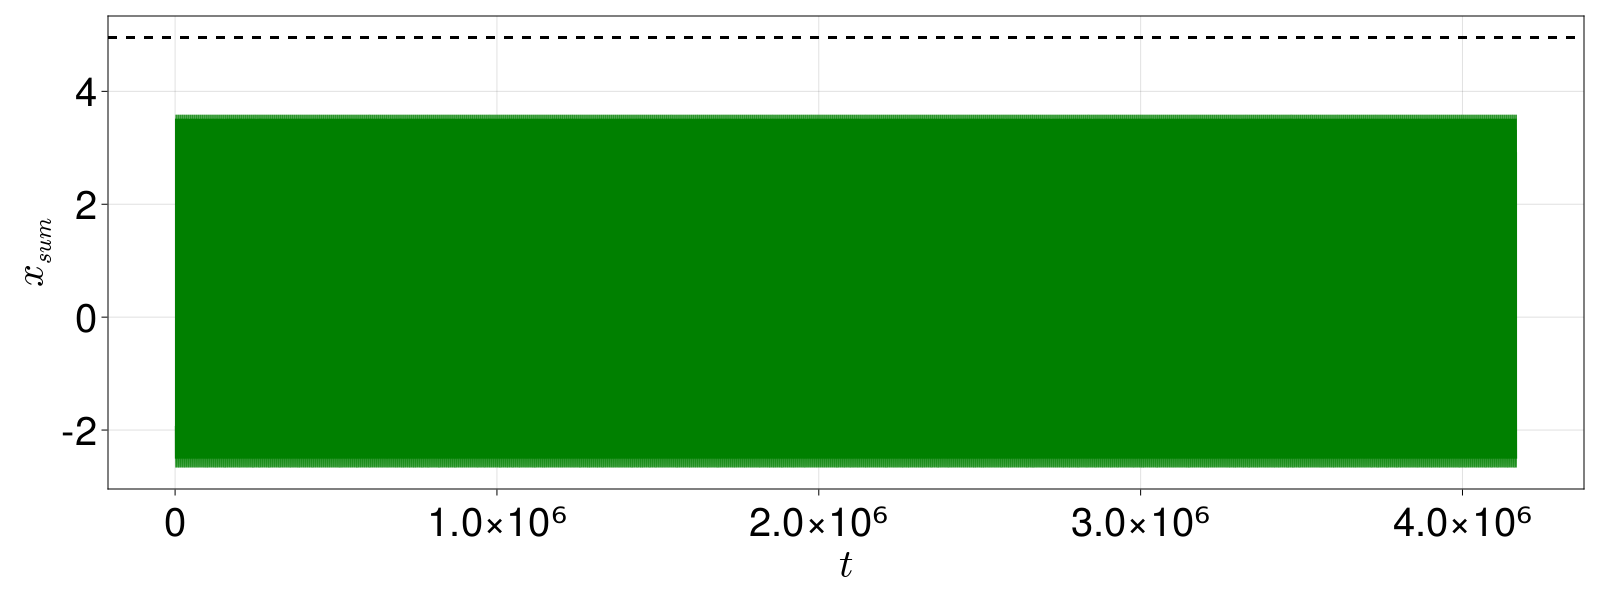

In [15]:
f = Figure(resolution = (1600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")

lines!(ax, xsum, linewidth = 0.5, color = "green")
hlines!(Hs1, color = "black", linewidth = 3.0, linestyle = :dash)

f

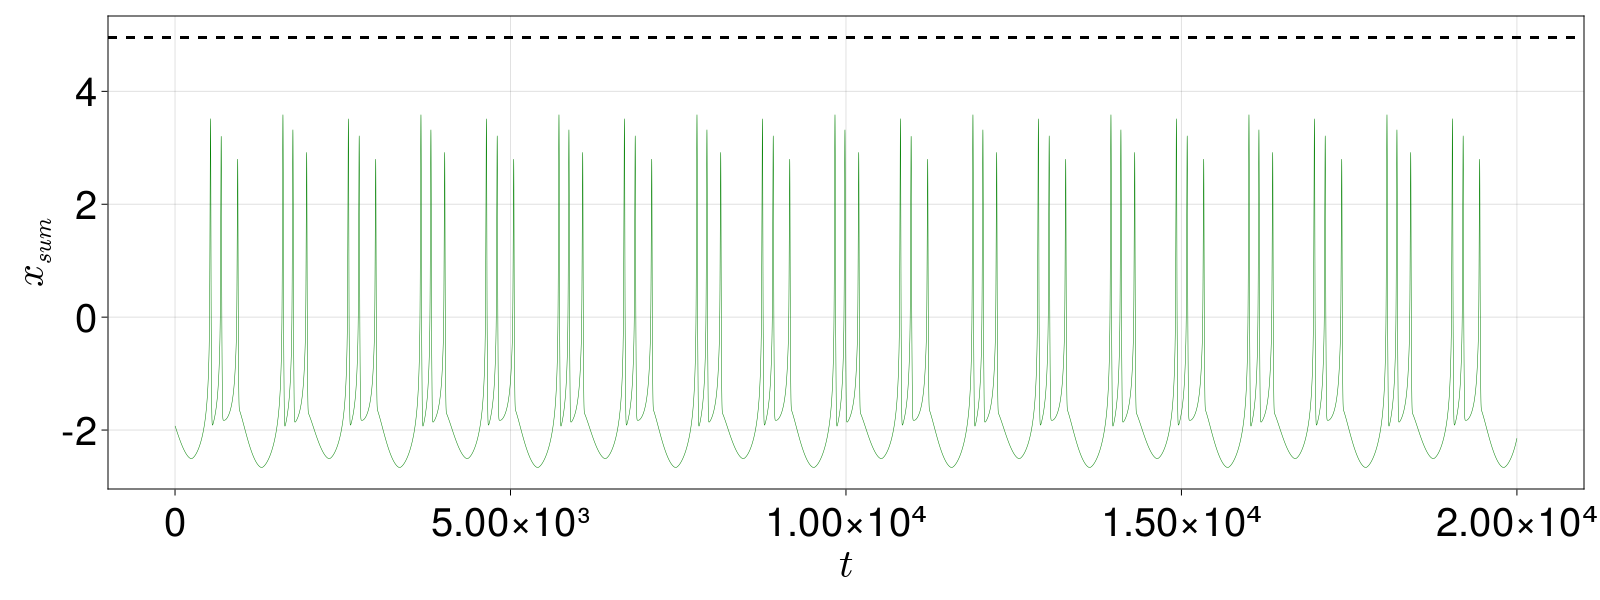

In [16]:
f = Figure(resolution = (1600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")

lines!(ax, xsum[1:20000], linewidth = 0.5, color = "green")
hlines!(Hs1, color = "black", linewidth = 3.0, linestyle = :dash)

f

In [17]:
sel_1, pdf_1 = CALCPDF(spikes)

(0.0:8.00000160000032e-7:4.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [18]:
using PyPlot

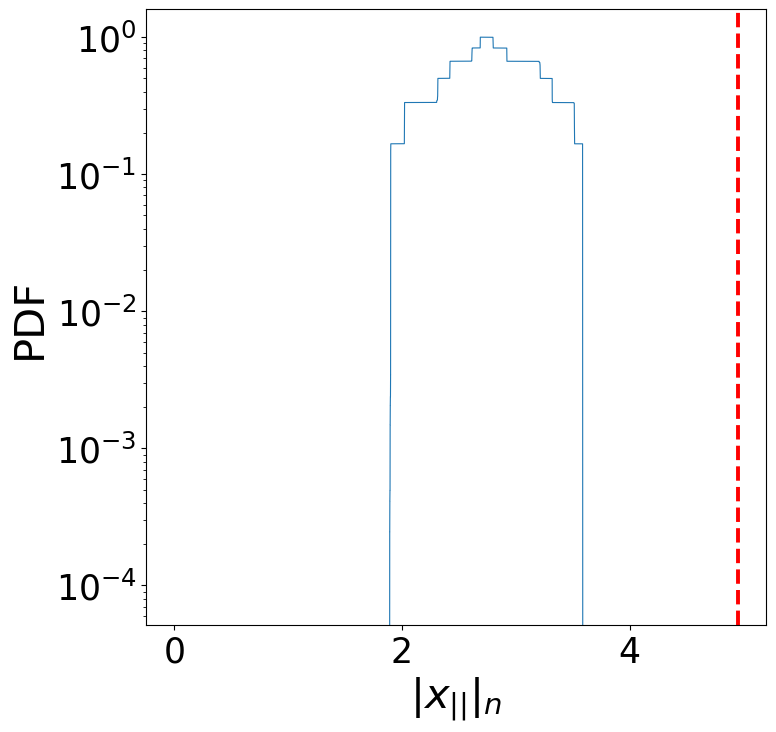

PyObject Text(50.0, 0.5, 'PDF')

In [19]:
counts = spikes[spikes.>=Hs1]
counts = length(counts)

fig, ax = subplots(figsize = (8, 8))

ax.set_yscale("log")

ax.plot(sel_1, pdf_1, label  = "k: $k", lw  = 0.8)
ax.axvline(Hs1, color ="red", linestyle ="--", lw = 2.8, label = "count: $counts")
ax.tick_params(labelsize = 25)

ax.set_xlabel(L"|x_{||}|_{n}", fontsize = 30)
ax.set_ylabel("PDF", fontsize = 30)

# ax.legend(loc="upper left", fontsize = 25)

In [20]:
ds = ContinuousDynamicalSystem(HR, condition_, p)
spectrum = lyapunovspectrum(ds, 300000.0; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
spectrum

6-element Vector{Float64}:
  0.013607681737415077
  0.009869246508168757
  4.289434518785145e-5
 -0.004374493616793723
 -8.826954537800114
 -9.560369145076065